### Load Trajectory, Trip, and Edge Data 

In [1]:
import pandas as pd
import numpy as np
import json
import datetime
from multiprocessing import Pool, cpu_count
from geopy.distance import great_circle
from tqdm import tqdm
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter

In [2]:
traj_col = ['ObjectID','Lon','Lat','StartMileage','Date','TripID', 'EdgeID','StartNode','EndNode','Reversed','EdgeDirect']
edge_col = ['EdgeID', 'TagID', 'LengthMeter', 'StartNode', 'EndNode', 'StartLng', 'StartLat', 'EndLng', 'EndLat']

In [5]:
dateparser = lambda x: pd.to_datetime(x)
trip_df = pd.read_csv('./data/trips.csv', index_col=['TripID'], parse_dates=['StartTime','StopTime'], date_parser=dateparser)
traj_df = pd.read_csv('./data/traj.csv', names=traj_col, parse_dates=['Date'], date_parser=dateparser)
edge_df = pd.read_csv('./data/edges.csv',names=edge_col)
poi_df = pd.read_csv('./data/poi.csv')

In [380]:
trip_df.head()

,ObjectID,StartTime,StartLon,StartLat,StopTime,StopLon,StopLat,TravelMileage,TravelOil,TravelPeriod,DrivePeriod,StartMileage,theDay
TripID,,,,,,,,,,,,,
0,123466,2016-06-30 23:23:00,113.890668,22.501852,2016-06-30 23:54:00,114.045657,22.599350,23713,2102.60,1825,1825,25137.766,01:04.0
1,479787,2016-06-30 20:47:00,113.916009,22.520198,2016-06-30 23:44:00,114.013164,22.544867,37504,3709.29,10601,10601,24900.100,08:46.8
2,543310,2016-06-30 22:45:00,113.903689,22.768964,2016-06-30 23:45:00,113.825084,22.805767,46597,3664.39,3621,3621,2643.285,09:44.4
3,115508,2016-07-01 08:45:00,113.907028,22.784393,2016-07-01 09:17:00,113.988817,22.735213,16369,1684.76,1878,1878,22147.148,24:22.0
4,125648,2016-07-01 08:58:00,113.941835,22.555053,2016-07-01 09:16:00,113.940610,22.549315,2953,482.95,1090,1090,61303.515,24:22.0


In [297]:
trips = len(trip_df)
start_date = trip_df.StartTime.dt.date.nunique()
end_date = trip_df.StopTime.dt.date.nunique()
start_time = min(trip_df.StartTime.dt.time)
end_time = max(trip_df.StopTime.dt.time)

print('--- Overview: Trip ---')
print(f'Trip count: {trips}')
print(f'Earliest date: {start_date}')
print(f'Latest date: {end_date}')
print(f'Earliest time: {start_time}')
print(f'Latest time: {end_time}')

--- Overview: Trip ---
Trip count: 242632
Earliest date: 40
Latest date: 40
Earliest time: 00:00:00
Latest time: 23:59:00


In [32]:
edge_df.head()

,EdgeID,TagID,LengthMeter,StartNode,EndNode,StartLng,StartLat,EndLng,EndLat
0,2,110,12.891966,3567,4056,114.045819,22.599486,114.045721,22.599413
1,3,109,15.884320,4542,2947,113.993670,22.674061,113.993528,22.674005
2,4,107,82.595372,13664,17697,113.823345,22.780179,113.822972,22.780840
3,5,108,115.266486,19104,21350,113.782299,22.721671,113.781177,22.721708
4,6,104,90.337625,21487,24111,114.235010,22.664874,114.235889,22.664895


In [299]:
edges = len(edge_df)
start = edge_df.StartNode.nunique()
end = edge_df.EndNode.nunique()
tags = edge_df.TagID.nunique()

print('--- Overview: Edge ---')
print(f'Edge count: {edges}')
print(f'Start node count: {start}')
print(f'End node count: {end}')
print(f'Tag count: {tags}')

--- Overview: Edge ---
Edge count: 51130
Start node count: 35245
End node count: 35989
Tag count: 11


In [27]:
traj_df.head()

,ObjectID,Lon,Lat,StartMileage,Date,TripID,EdgeID,StartNode,EndNode,Reversed,EdgeDirect
0,30426,113.943635,22.763677,14677.706,2016-07-04 19:27:29,26850,46419,36826,30794,False,True
1,30426,113.942022,22.764273,14677.936,2016-07-04 19:28:06,26850,46419,36826,30794,False,True
2,30426,113.942022,22.764273,14678.166,2016-07-04 19:28:44,26850,46419,36826,30794,False,False
3,30426,113.943077,22.763702,14678.396,2016-07-04 19:29:22,26850,46419,36826,30794,False,False
4,30426,113.943787,22.763293,14720.036,2016-07-06 08:36:29,37102,46419,36826,30794,False,None


In [294]:
trajs = len(traj_df)
vehicles = traj_df['ObjectID'].nunique()
trips = traj_df['TripID'].nunique()
dates = traj_df['Date'].dt.date.nunique()
edges = traj_df['EdgeID'].nunique()

print('--- Overview: Trajectory ---')
print(f'Trajectory count: {trajs}')
print(f'Vehicle count: {vehicles}')
print(f'Trip count: {trips}')
print(f'Date count: {dates}')
print(f'Edge count: {edges}')

--- Overview: Trajectory ---
Trajectory count: 17779476
Vehicle count: 3303
Trip count: 214657
Date count: 35
Edge count: 42997


In [381]:
poi_df.head()

,longitude,latitude,category,tag,name,new_tag
0,114.0431,22.600976,amenity,fuel,NaN,transportation
1,113.858464,22.614462,amenity,school,Tsinghua Experimental School,education
2,114.086044,22.551146,amenity,fuel,NaN,transportation
3,113.855042,22.614215,amenity,fuel,NaN,transportation
4,114.08721,22.550797,amenity,fire_station,NaN,amenity_others


In [382]:
pois = len(poi_df)
tags = poi_df['new_tag'].nunique()

print('--- Overview: Point of Interest ---')
print(f'Trajectory count: {pois}')
print(f'Tag count: {tags}')

--- Overview: Point of Interest ---
Trajectory count: 9874
Tag count: 19


### Time-dependent features

In [64]:
# Helper functions
def get_distance(loc, next_loc):
    """
    Calculate great circle distance as distance travelled per time interval
    """
    return great_circle(loc, next_loc).meters 

def calculate_speed(row):
    """
    Calculate travelling speed per time interval
    """
    row['SecondsTravelled'] = (row['Date_shift'] - row['Date']).dt.total_seconds()
    row['Speed(m/s)'] = row['MetersTravelled']/row['SecondsTravelled']
    row['Speed(km/h)'] = row['Speed(m/s)']/1000*3600 
    return row

def check_weekday(row):
    """
    Label data with weekday/weekend
    """
    day = row['Date'].dt.dayofweek 
    row['Weekday'] = 0 if day > 4 else 1
    return row

def parallelize_df(df, func, n_cores=cpu_count()):
    """
    Multi-processing using context manager
    """
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def get_trip_duration(group):
    """
    Get the duration of each trip
    """
    duration = (group.max() - group.min()).total_seconds()/60
    return {"Duration": duration}

In [9]:
traj_df = traj_df[traj_df.groupby('TripID').TripID.transform('count') > 1]
tmp = traj_df.groupby('TripID')['Date', 'Lon', 'Lat'].shift(-1).add_suffix('_shift')
traj_df = pd.concat([traj_df, tmp], axis=1)
traj_df = traj_df[traj_df['Date_shift'].notna()]
traj_df.head()

,ObjectID,Lon,Lat,StartMileage,Date,TripID,EdgeID,StartNode,EndNode,Reversed,EdgeDirect,Date_shift,Lon_shift,Lat_shift
0,30426,113.943635,22.763677,14677.706,2016-07-04 19:27:29,26850,46419,36826,30794,False,True,2016-07-04 19:28:06,113.942022,22.764273
1,30426,113.942022,22.764273,14677.936,2016-07-04 19:28:06,26850,46419,36826,30794,False,True,2016-07-04 19:28:44,113.942022,22.764273
2,30426,113.942022,22.764273,14678.166,2016-07-04 19:28:44,26850,46419,36826,30794,False,False,2016-07-04 19:29:22,113.943077,22.763702
5,30426,113.943873,22.763408,14721.794,2016-07-06 19:38:15,46400,46419,36826,30794,False,True,2016-07-06 19:38:58,113.942827,22.763898
6,30426,113.942827,22.763898,14722.026,2016-07-06 19:38:58,46400,46419,36826,30794,False,True,2016-07-06 19:39:41,113.941838,22.764405


In [21]:
%%time
traj_df.apply(lambda x: get_distance((x['Lat'], x['Lon']), (x['Lat_shift'], x['Lon_shift'])), axis=1)
traj_df = parallelize_df(traj_df, calculate_speed)
traj_df.head()

CPU times: user 18.2 s, sys: 33.8 s, total: 52 s
Wall time: 2min 15s


,ObjectID,Lon,Lat,StartMileage,Date,TripID,EdgeID,StartNode,EndNode,Reversed,EdgeDirect,Date_shift,Lon_shift,Lat_shift,MetersTravelled,SecondsTravelled,Speed(m/s),Speed(km/h)
0,30426.0,113.943635,22.763677,14677.706,2016-07-04 19:27:29,26850.0,46419.0,36826.0,30794.0,False,True,2016-07-04 19:28:06,113.942022,22.764273,178.170814,37.0,4.815427,17.335539
1,30426.0,113.942022,22.764273,14677.936,2016-07-04 19:28:06,26850.0,46419.0,36826.0,30794.0,False,True,2016-07-04 19:28:44,113.942022,22.764273,0.000000,38.0,0.000000,0.000000
2,30426.0,113.942022,22.764273,14678.166,2016-07-04 19:28:44,26850.0,46419.0,36826.0,30794.0,False,False,2016-07-04 19:29:22,113.943077,22.763702,125.430046,38.0,3.300791,11.882847
5,30426.0,113.943873,22.763408,14721.794,2016-07-06 19:38:15,46400.0,46419.0,36826.0,30794.0,False,True,2016-07-06 19:38:58,113.942827,22.763898,120.296946,43.0,2.797603,10.071372
6,30426.0,113.942827,22.763898,14722.026,2016-07-06 19:38:58,46400.0,46419.0,36826.0,30794.0,False,True,2016-07-06 19:39:41,113.941838,22.764405,116.023115,43.0,2.698212,9.713563


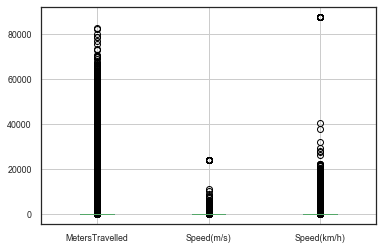

In [388]:
traj_df.boxplot(column=['MetersTravelled', 'Speed(m/s)', 'Speed(km/h)'])
plt.show()

In [32]:
traj_df[['MetersTravelled', 'Speed(m/s)', 'Speed(km/h)']].describe()

,MetersTravelled,Speed(m/s),Speed(km/h)
count,1.782761e+07,1.782761e+07,1.782761e+07
mean,1.566286e+02,inf,inf
std,6.188856e+02,NaN,NaN
min,1.024909e-01,3.079367e-04,1.108572e-03
25%,4.857671e+01,2.421893e+00,8.718815e+00
50%,9.894179e+01,5.204803e+00,1.873729e+01
75%,1.718343e+02,9.410986e+00,3.387955e+01
max,8.294245e+04,inf,inf


In [37]:
traj_df = traj_df[traj_df['Speed(m/s)'] > 0]
m_mean = traj_df.loc[traj_df['Speed(m/s)'] != np.inf, 'Speed(m/s)'].max()
km_mean = traj_df.loc[traj_df['Speed(km/h)'] != np.inf, 'Speed(km/h)'].max()
traj_df['Speed(m/s)'].replace(np.inf, m_mean, inplace=True)
traj_df['Speed(km/h)'].replace(np.inf, km_mean, inplace=True)
traj_df[['MetersTravelled', 'Speed(m/s)', 'Speed(km/h)']].describe()

,MetersTravelled,Speed(m/s),Speed(km/h)
count,1.782761e+07,1.782761e+07,1.782761e+07
mean,1.566286e+02,7.605187e+00,2.737867e+01
std,6.188856e+02,4.452424e+01,1.602873e+02
min,1.024909e-01,3.079367e-04,1.108572e-03
25%,4.857671e+01,2.421893e+00,8.718815e+00
50%,9.894179e+01,5.204803e+00,1.873729e+01
75%,1.718343e+02,9.410986e+00,3.387955e+01
max,8.294245e+04,2.437133e+04,8.773678e+04


In [305]:
traj_df['Speed(km/h)'] = traj_df['Speed(m/s)']/1000*3600 

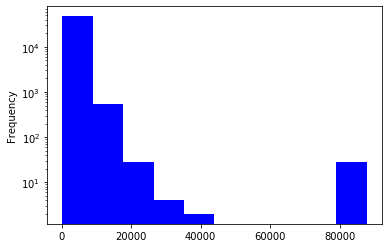

215.13432693470676 87736.77620147822


In [308]:
outliers = traj_df[traj_df['Speed(km/h)'] > traj_df['Speed(km/h)'].quantile(0.9973)].sort_values(by='Speed(km/h)', ascending=False)
outliers['Speed(km/h)'].plot.hist(bins=10, logy=True, color='blue')
plt.show()
print(outliers['Speed(km/h)'].min(), outliers['Speed(km/h)'].max())

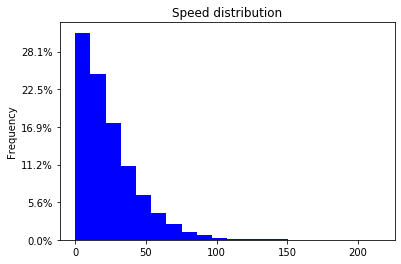

Trajectory data: 17779476


In [126]:
traj_df.drop(outliers.index, axis=0, inplace=True)
ax = traj_df['Speed(km/h)'].plot.hist(bins=20, color='blue', title='Speed distribution')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(traj_df)))
plt.show()
print(f'Trajectory data: {len(traj_df)}')

In [234]:
%%time
trip_duration = traj_df['Date'].groupby(traj_df['TripID']).apply(get_trip_duration).unstack()

CPU times: user 2min 9s, sys: 3.5 s, total: 2min 13s
Wall time: 5min 6s


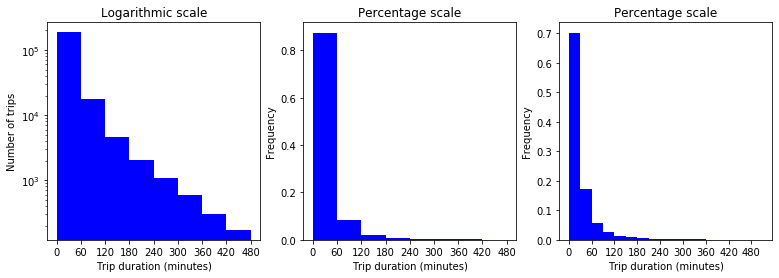

In [320]:
interval60 = [i*60 for i in range(9)]
interval30 = [i*30 for i in range(18)]

plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
ax1 = trip_duration['Duration'].plot.hist(bins=interval60, log=True, color='blue', title='Logarithmic scale')
ax1.set_xlabel('Trip duration (minutes)')
ax1.set_ylabel('Number of trips')
ax1.set_xticks(np.arange(0, 490, 60))

plt.subplot(1,3,2)
ax2 = trip_duration['Duration'].plot.hist(bins=interval60, weights=np.ones(len(trip_duration))/len(trip_duration),  
                                          color='blue', title='Percentage scale')
ax2.set_xlabel('Trip duration (minutes)')
ax2.set_xticks(np.arange(0, 490, 60))

plt.subplot(1,3,3)
ax3 = trip_duration['Duration'].plot.hist(weights=np.ones(len(trip_duration))/len(trip_duration), bins=interval30, 
                                          color='blue', title='Percentage scale')
ax3.set_xlabel('Trip duration (minutes)')
ax3.set_xticks(np.arange(0, 490, 60))
plt.show()

            Duration
count  214657.000000
mean       30.610676
std        54.572665
min         0.000000
25%         5.383333
50%        15.100000
75%        35.300000
max      8297.816667


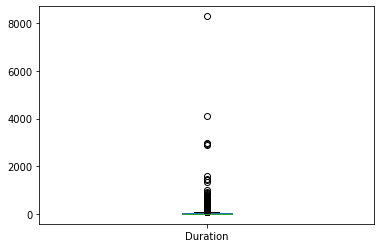

In [318]:
print(trip_duration.describe())
trip_duration.plot(kind='box')
plt.show()

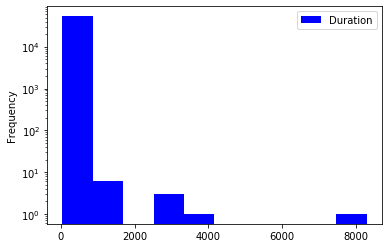

In [328]:
trip_duration[trip_duration['Duration'] > trip_duration['Duration'].quantile(0.75)].plot.hist(logy=True, color='blue')
plt.show()

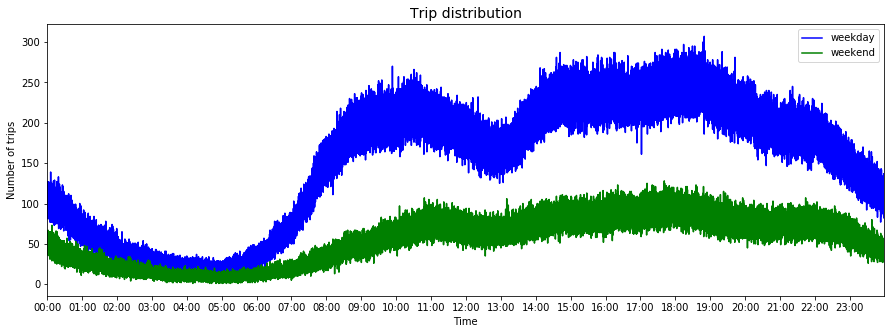

In [75]:
traj_df = parallelize_df(traj_df, check_weekday)
weekday = traj_df[traj_df['Weekday']==1]
weekend = traj_df[traj_df['Weekday']==0]

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(weekday.groupby(weekday['Date'].dt.time)['TripID'].nunique(), '-b', label='weekday')
plt.plot(weekend.groupby(weekend['Date'].dt.time)['TripID'].nunique(), '-g', label='weekend')
plt.legend(loc='upper right')
plt.xticks(pd.date_range('00:00', '23:59', freq='1H').time)
plt.xlim(datetime.time(0,0), datetime.time(23,59))
plt.title('Trip distribution')
plt.xlabel('Time')
plt.ylabel('Number of trips')
plt.show()

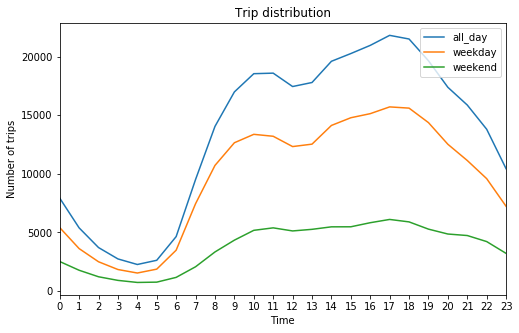

In [88]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(traj_df.groupby(traj_df['Date'].dt.hour)['TripID'].nunique(), label='all_day')
plt.plot(weekday.groupby(weekday['Date'].dt.hour)['TripID'].nunique(), label='weekday')
plt.plot(weekend.groupby(weekend['Date'].dt.hour)['TripID'].nunique(), label='weekend')

plt.legend(loc='upper right')
plt.xlim(0, 23)
plt.xticks(np.arange(0, 24, 1))
plt.title('Trip distribution')
plt.xlabel('Time')
plt.ylabel('Number of trips')
plt.show()

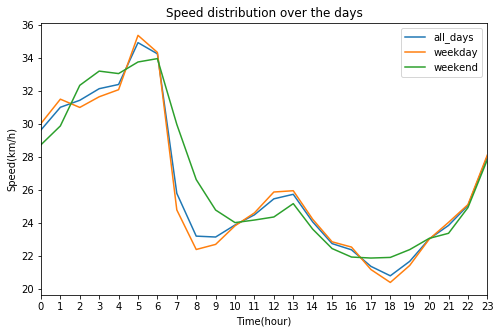

In [85]:
avg_speed = traj_df.groupby(traj_df['Date'].dt.hour).mean()
avg_wd = weekday.groupby(weekday['Date'].dt.hour).mean()
avg_we = weekend.groupby(weekend['Date'].dt.hour).mean()

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(avg_speed['Speed(km/h)'], label='all_days')
plt.plot(avg_wd['Speed(km/h)'], label='weekday')
plt.plot(avg_we['Speed(km/h)'], label='weekend')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 24, 1))
plt.title('Speed distribution over the days')
plt.xlabel('Time(hour)')
plt.ylabel('Speed(km/h)')
plt.show()

In [292]:
avg_vehicle = len(traj_df)/traj_df['ObjectID'].nunique()
avg_day = len(traj_df)/traj_df['Date'].dt.time.nunique()
avg_hour = len(traj_df)/traj_df['Date'].dt.hour.nunique()
avg_min = len(traj_df)/traj_df['Date'].dt.time.nunique()
total_weekday = len(traj_df[traj_df['Weekday']==1])
total_weekend = len(traj_df[traj_df['Weekday']==0]) 

print('--- Data Summary: Trajectory ---')
print(f'Average trajectory per vehicle: {avg_vehicle}')
print(f'Average trajectory per day: {avg_day}')
print(f'Average trajectory per hour: {avg_hour}')
print(f'Average trajectory per min: {avg_min}')
print(f'Total trajectory in weekdays: {total_weekday}')
print(f'Total trajectory in weekend: {total_weekend}')

--- Data Summary: Trajectory ---
Average trajectory per vehicle: 5382.826521344233
Average trajectory per day: 205.78097222222223
Average trajectory per hour: 740811.5
Average trajectory per min: 205.78097222222223
Total trajectory in weekdays: 13082491
Total trajectory in weekend: 4696985


In [289]:
avg_vehicle = len(trip_df)/trip_df['ObjectID'].nunique()
avg_day = len(trip_df)/trip_df['StartTime'].dt.date.nunique()
avg_hour = len(trip_df)/trip_df['StartTime'].dt.hour.nunique()
avg_min = len(trip_df)/trip_df['StartTime'].dt.time.nunique()
total_weekday = len(trip_df[trip_df['StartTime'].dt.dayofweek < 5])
total_weekend = len(trip_df[trip_df['StartTime'].dt.dayofweek > 4])

print('--- Data Summary: Trip ---')
print(f'Average trips per vehicle: {avg_vehicle}')
print(f'Average trips per day: {avg_day}')
print(f'Average trips per hour: {avg_hour}')
print(f'Average trips per min: {avg_min}')
print(f'Total trips in weekdays: {total_weekday}')
print(f'Total trips in weekend: {total_weekend}')

--- Data Summary: Trip ---
Average trips per vehicle: 69.46235327798453
Average trips per day: 6065.8
Average trips per hour: 10109.666666666666
Average trips per min: 168.49444444444444
Total trips in weekdays: 165519
Total trips in weekend: 77113


### Geospatial features - point-of-interests, road type

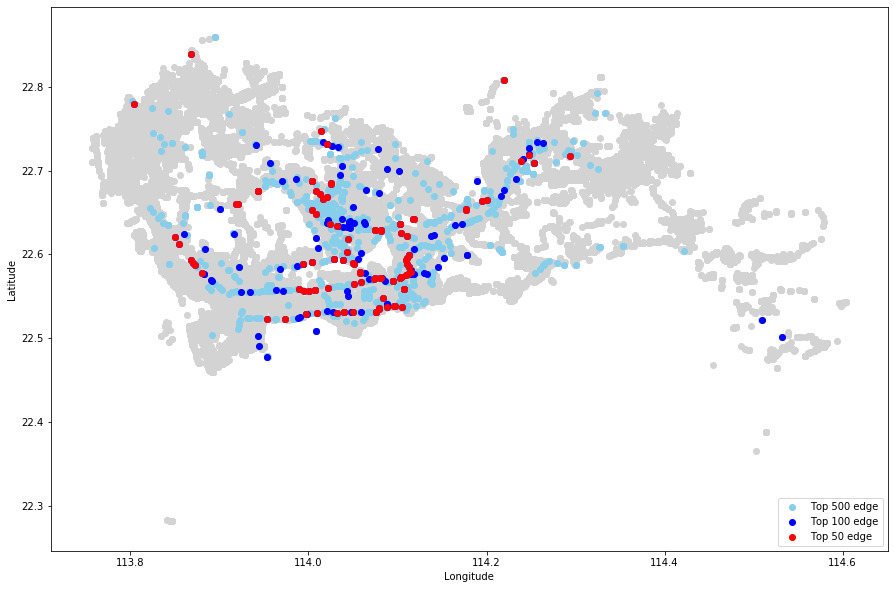

In [198]:
c = Counter(traj_df['EdgeID'])
edge_50 = edge_df[edge_df['EdgeID'].isin([i[0] for i in c.most_common(50)])]
edge_100 = edge_df[edge_df['EdgeID'].isin([i[0] for i in c.most_common(100)])]
edge_500 = edge_df[edge_df['EdgeID'].isin([i[0] for i in c.most_common(500)])]

plt.figure(figsize=(15,10))
plt.scatter(edge_df['StartLng'].append(edge_df['EndLng']), 
            edge_df['StartLat'].append(edge_df['EndLat']), color='lightgray')
top_500 = plt.scatter(edge_500['StartLng'].append(edge_500['EndLng']), 
                       edge_500['StartLat'].append(edge_500['EndLat']), color='skyblue')
top_100 = plt.scatter(edge_100['StartLng'].append(edge_100['EndLng']), 
                       edge_100['StartLat'].append(edge_100['EndLat']), color='blue')
top_50 = plt.scatter(edge_50['StartLng'].append(edge_50['EndLng']), 
                      edge_50['StartLat'].append(edge_50['EndLat']), color='red')
plt.legend((top_500, top_100, top_50), ('Top 500 edge', 'Top 100 edge', 'Top 50 edge'), loc='lower right')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

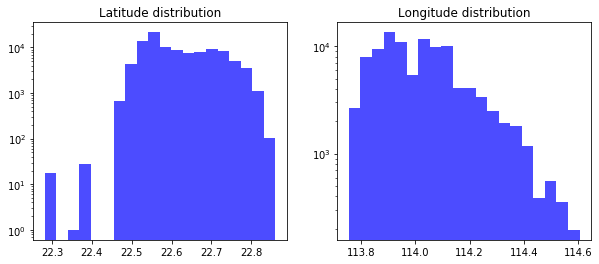

In [246]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(edge_df['StartLat'].append(edge_df['EndLat']), bins=20, color='blue', alpha=0.7, log=True)
ax1.set_title('Latitude distribution')

ax2.hist(edge_df['StartLng'].append(edge_df['EndLng']), bins=20, color='blue', alpha=0.7, log=True)
ax2.set_title('Longitude distribution')
plt.show()

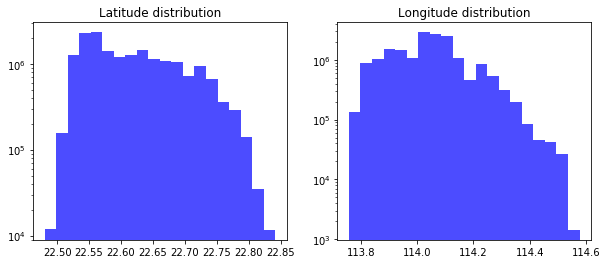

In [207]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(traj_df['Lat'], bins=20, color='blue', alpha=0.7, log=True)
ax1.set_title('Latitude distribution')

ax2.hist(traj_df['Lon'], bins=20, color='blue', alpha=0.7, log=True)
ax2.set_title('Longitude distribution')
plt.show()

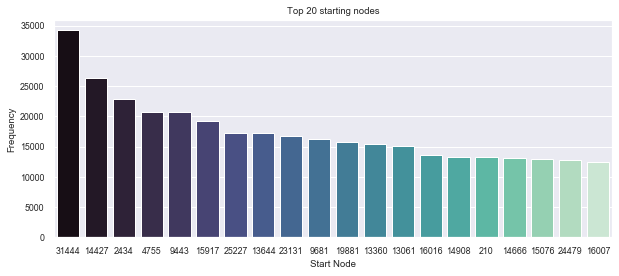

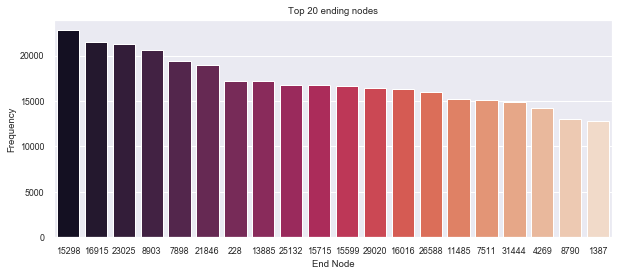

In [364]:
top_start = pd.DataFrame(traj_df['StartNode'].value_counts()[:20])
top_start.reset_index(inplace=True)
top_end = pd.DataFrame(traj_df['EndNode'].value_counts()[:20])
top_end.reset_index(inplace=True)

sns.set(font_scale=0.8)
plt.figure(figsize=(10,4))
ax = sns.barplot(x='index', y='StartNode', data=top_start, palette='mako', order=top_start['index'])
ax.set(xlabel='Start Node', ylabel='Frequency', title='Top 20 starting nodes')
plt.show()

sns.set(font_scale=0.8)
plt.figure(figsize=(10,4))
ax = sns.barplot(x='index', y='EndNode', data=top_end, palette='rocket', order=top_end['index'])
ax.set(xlabel='End Node', ylabel='Frequency', title='Top 20 ending nodes')
plt.show()

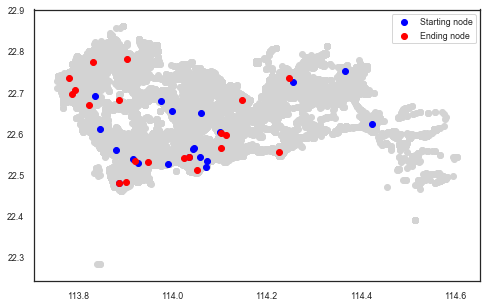

In [387]:
plt.figure(figsize=(8,5))
top_start = edge_df[['StartLng', 'StartLat']].loc[edge_df['EdgeID'].isin(top_start['index'])]
top_end = edge_df[['EndLng', 'EndLat']].loc[edge_df['EdgeID'].isin(top_end['index'])]
plt.scatter(edge_df['StartLng'], edge_df['StartLat'], color='lightgray')
plt.scatter(top_start['StartLng'], top_start['StartLat'], color='blue', label='Starting node')
plt.scatter(top_end['EndLng'], top_end['EndLat'], color='red', label='Ending node')
plt.legend()
plt.show()

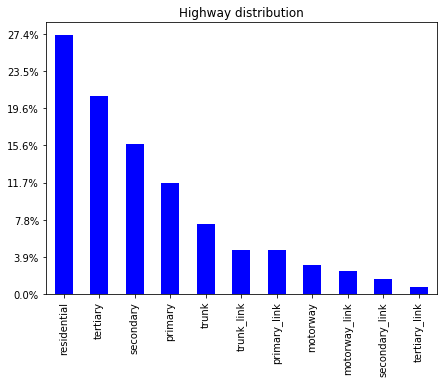

In [222]:
with open('tags_highway.json', 'r') as fp:
    highway_tags = json.load(fp)
    
highway_tags = {int(k): v for k,v in highway_tags.items()}
edge_df['Highway'] = edge_df['TagID'].map(highway_tags)
ax = edge_df['Highway'].value_counts().sort_values(ascending=False).plot(kind='bar', title='Highway distribution', colors='blue', figsize=(7, 5))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(edge_df)))

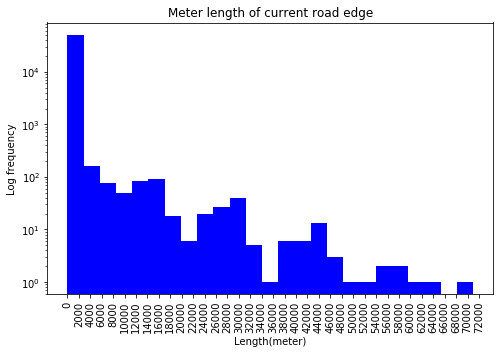

In [229]:
plt.figure(figsize=(8,5))
ax = edge_df['LengthMeter'].plt.hist(bins=25, color='blue', log=True, title='Length distribution of road edge')
ax.set_xticks([i*2000 for i in range(15*5//2)], rotation=90)
ax.set_ylabel('Log frequency')
ax.set_xlabel('Length(meter)')
plt.show()

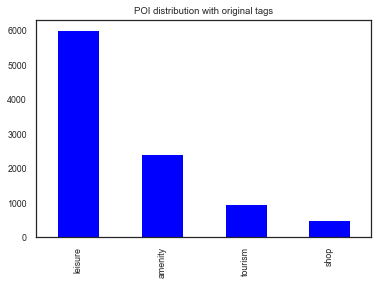

In [389]:
poi_df['category'].value_counts().plot(kind='bar', color='blue', title='POI distribution with original tags')
plt.show()

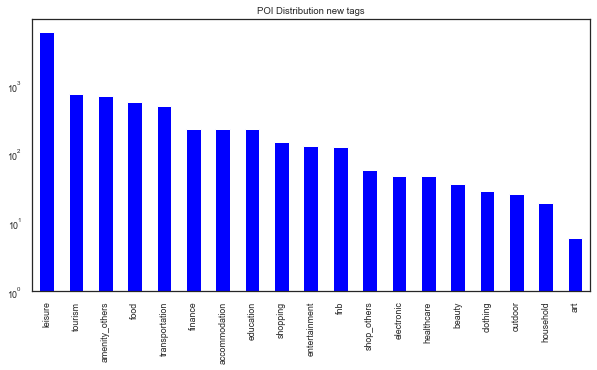

In [391]:
poi_df['new_tag'].value_counts().plot(kind='bar', color='blue', log=True, figsize=(10,5), title='POI Distribution new tags')
plt.show()

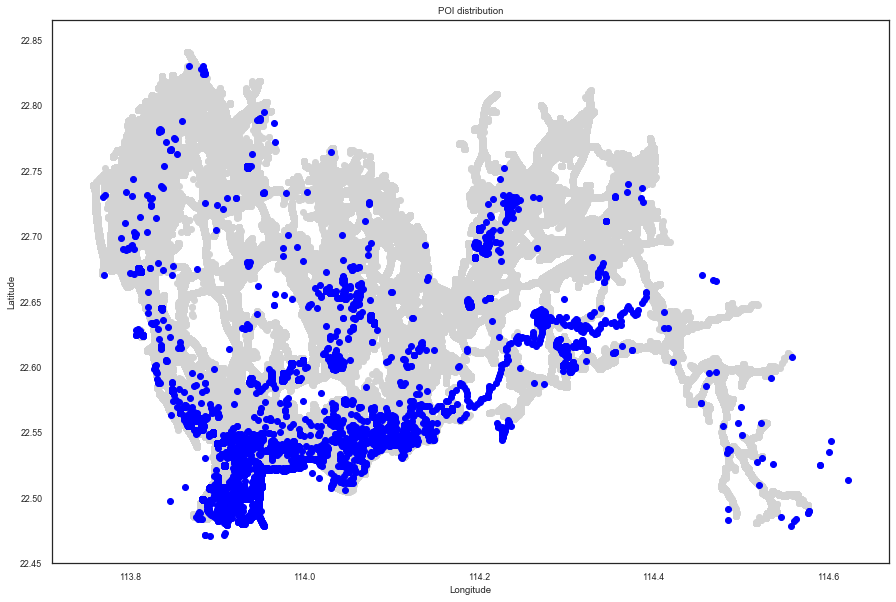

In [542]:
plt.figure(figsize=(15,10))
plt.scatter(traj_df['Lon'], traj_df['Lat'], color='lightgray')
plt.scatter(poi_df['longitude'], poi_df['latitude'], color='blue')
plt.title('POI distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

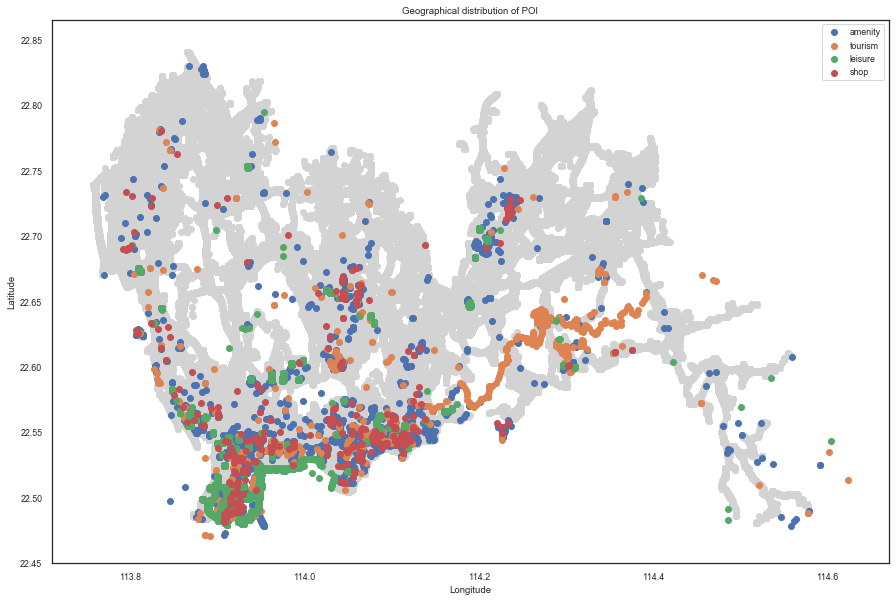

In [541]:
plt.figure(figsize=(15,10))
plt.scatter(traj_df['Lon'], traj_df['Lat'], color='lightgray')
for tag in poi_df['category'].unique():
    tmp_df = poi_df[poi_df['category']==tag]
    plt.scatter(tmp_df['longitude'], tmp_df['latitude'], label=tag)
plt.title('POI distribution with original tags')
plt.legend(loc='upper right')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

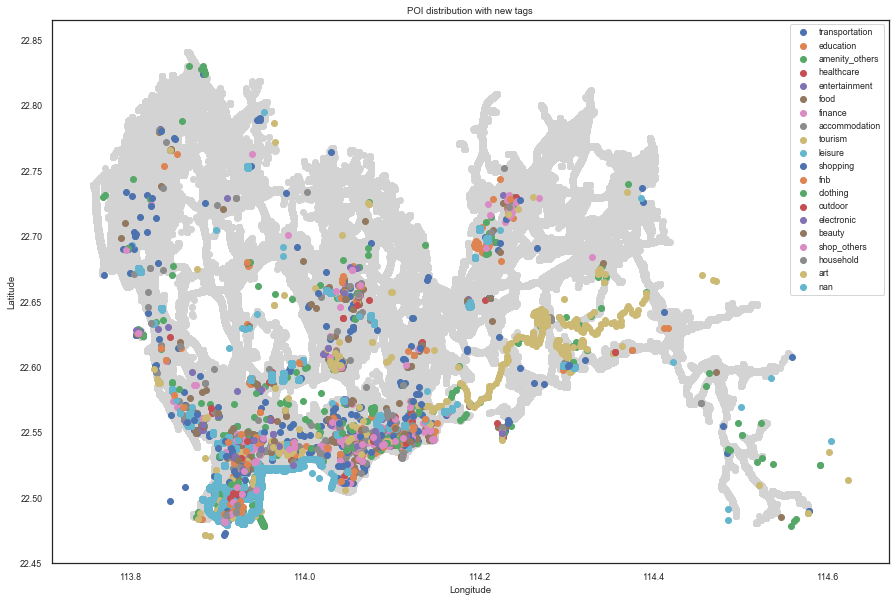

In [543]:
plt.figure(figsize=(15,10))
plt.scatter(traj_df['Lon'], traj_df['Lat'], color='lightgray')
for tag in poi_df['new_tag'].unique():
    tmp_df = poi_df[poi_df['new_tag']==tag]
    plt.scatter(tmp_df['longitude'], tmp_df['latitude'], label=tag)
plt.title('POI distribution with new tags')
plt.legend(loc='upper right')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()